# Create Enviornment

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install -q sentence-transformers faiss-cpu pandas openai --upgrade
!pip install snowflake
!pip install hf_xet

import snowflake.connector
import os
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss
from openai import OpenAI
import pickle



Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 94.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.9/680.9 kB 40.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

# Load Keys

In [2]:
api_key_path = "/content/drive/Othercomputers/My Mac/CSCI_104/credentials/openaikey.txt"
sf_creds_path = '/content/drive/Othercomputers/My Mac/Git/credentials/snowflake_credentials.txt'


# === Read OpenAI API key from file ===
with open(api_key_path, 'r') as file:
    openai_api_key = file.read().strip()

# Create OpenAI client
client = OpenAI(api_key=openai_api_key)


# Load Corpus

In [3]:
# === Alternate flow to fetch forum data from Google Drive ===
# === Production implementations would use a database like Snowflake ===

df = pd.read_csv(f'https://drive.google.com/uc?export=download&id=1-Moxt8gEFeoHNk-VQRWG-G9EwxclQwh6',
                 usecols=['thread_id', 'thread_title', 'thread_first_post', 'thread_all_posts'])

# === Prepare Combined Text ===
df["full_text"] = (
    df["thread_title"].fillna("") + "\n\n" +
    df["thread_first_post"].fillna("") + "\n\n" +
    df["thread_all_posts"].fillna("")
)

# Embedding

In [4]:

# === Embed Corpus ===
model = SentenceTransformer("all-MiniLM-L6-v2")
corpus_embeddings = model.encode(df["full_text"].tolist(), show_progress_bar=True)

# === Create FAISS Index ===
dimension = corpus_embeddings.shape[1]
index = faiss.IndexFlatL2(dimension)
index.add(corpus_embeddings)

# === Ask a Sample Question ===
question = "How do I remove the steering wheel in an E9?"
question_embedding = model.encode([question])

top_k = 3
distances, indices = index.search(question_embedding, top_k)

print("\nRetrieved top threads:\n")
retrieved_texts = []
for i, (idx, dist) in enumerate(zip(indices[0], distances[0])):
    title = df.iloc[idx]["thread_title"]
    print(f"[{i+1}] {title} (Distance: {dist:.4f})")
    retrieved_texts.append(df.iloc[idx]["full_text"])

# === Build Prompt for RAG ===
context = "\n\n".join([f"Thread {i+1}:\n{text}" for i, text in enumerate(retrieved_texts)])
rag_prompt = f"""You are an expert on BMW E9 maintenance. Use the following forum threads to answer the question.

{context}

Question: {question}
Answer:"""

baseline_prompt = f"""You are an expert on BMW E9 maintenance.

Question: {question}
Answer:"""

# === Get LLM Responses ===
response_with_context = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": rag_prompt}],
    temperature=0.2
)

response_without_context = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[{"role": "user", "content": baseline_prompt}],
    temperature=0.2
)

# === Export FAISS Index and Data ===
print("\n[Step] Exporting FAISS index and thread data to disk...")

output_dir = '/content/drive/Othercomputers/My Mac/CSCI_104/Week_Project/App/'
os.makedirs(output_dir, exist_ok=True)

faiss_path = os.path.join(output_dir, "LLM_RAG_index.faiss")
df_path = os.path.join(output_dir, "LLM_RAG_threads.pkl")
sample_csv_path = os.path.join(output_dir, "LLM_RAG_index_sample.csv")

# Save index and data
faiss.write_index(index, faiss_path)
with open(df_path, "wb") as f:
    pickle.dump(df, f)
df[['thread_id', 'thread_title']].head(100).to_csv(sample_csv_path, index=False)

# === Report Export Status ===
if os.path.exists(faiss_path) and os.path.exists(df_path):
    faiss_size = os.path.getsize(faiss_path) / 1024 / 1024
    pkl_size = os.path.getsize(df_path) / 1024 / 1024

    print(f"[Success] Files exported to:\n  {output_dir}")
    print(f"  - FAISS index:  {os.path.basename(faiss_path)} ({faiss_size:.2f} MB)")
    print(f"  - Thread data:  {os.path.basename(df_path)} ({pkl_size:.2f} MB)")
else:
    print("[Error] Export failed. One or more files were not created.")

# === Show LLM Answers ===
print("\n=== ANSWER WITH RAG CONTEXT ===\n")
print(response_with_context.choices[0].message.content)

print("\n=== BASELINE ANSWER (No RAG) ===\n")
print(response_without_context.choices[0].message.content)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/471 [00:00<?, ?it/s]


Retrieved top threads:

[1] Formuling steering wheel with BMW adapter from E9 (Distance: 0.6596)
[2] Nardi Steering Wheel (Distance: 0.7089)
[3] Steering wheel on eBay (Distance: 0.7424)

[Step] Exporting FAISS index and thread data to disk...
[Success] Files exported to:
  /content/drive/Othercomputers/My Mac/CSCI_104/Week_Project/App/
  - FAISS index:  LLM_RAG_index.faiss (22.04 MB)
  - Thread data:  LLM_RAG_threads.pkl (78.08 MB)

=== ANSWER WITH RAG CONTEXT ===

To remove the steering wheel in an E9, you will first need to remove the horn button cover. This can typically be done by carefully inserting a fingernail underneath the cover and popping it off. Once the horn button cover is removed, you will likely see a nut securing the steering wheel to the steering column. You will need to use the appropriate tools to loosen and remove this nut. Once the nut is removed, you should be able to pull the steering wheel off the steering column. Be sure to disconnect any electrical connecti

# Visualization

Top 1000 Documents Statistics:
- Mean Distance: 1.3405
- Median Distance: 1.3802
- Min Distance (Best Match): 0.6620
- Max Distance (1000th Match): 1.4598
- 10th Percentile: 1.1901
- 90th Percentile: 1.4480


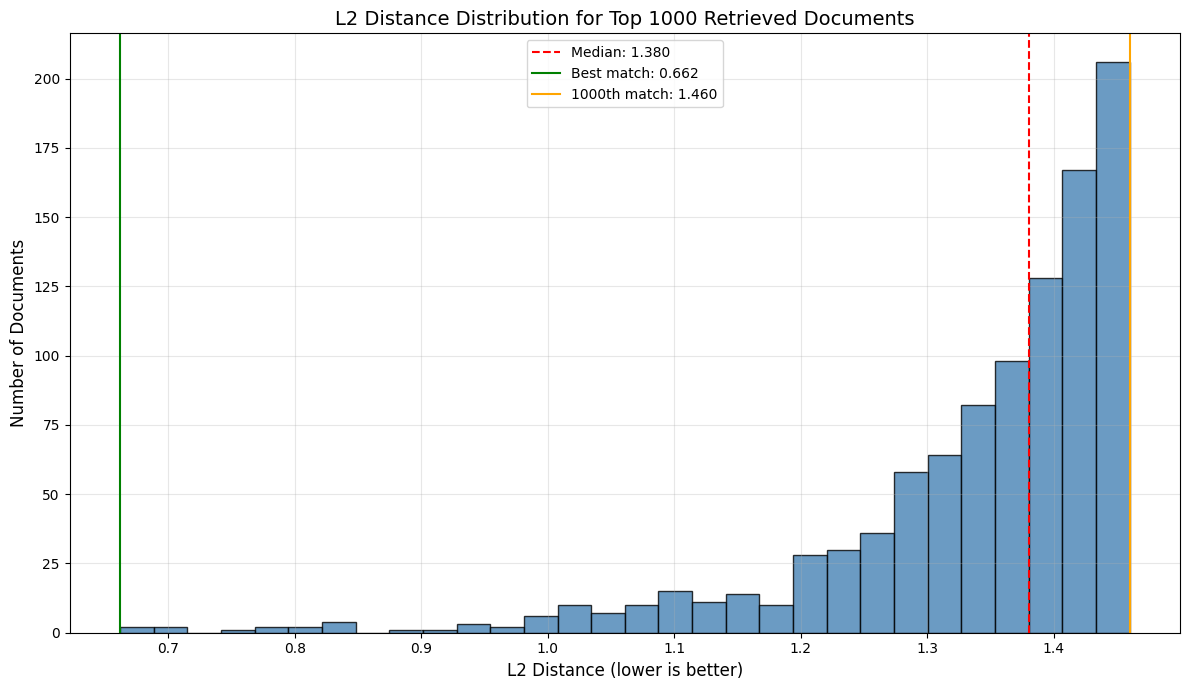

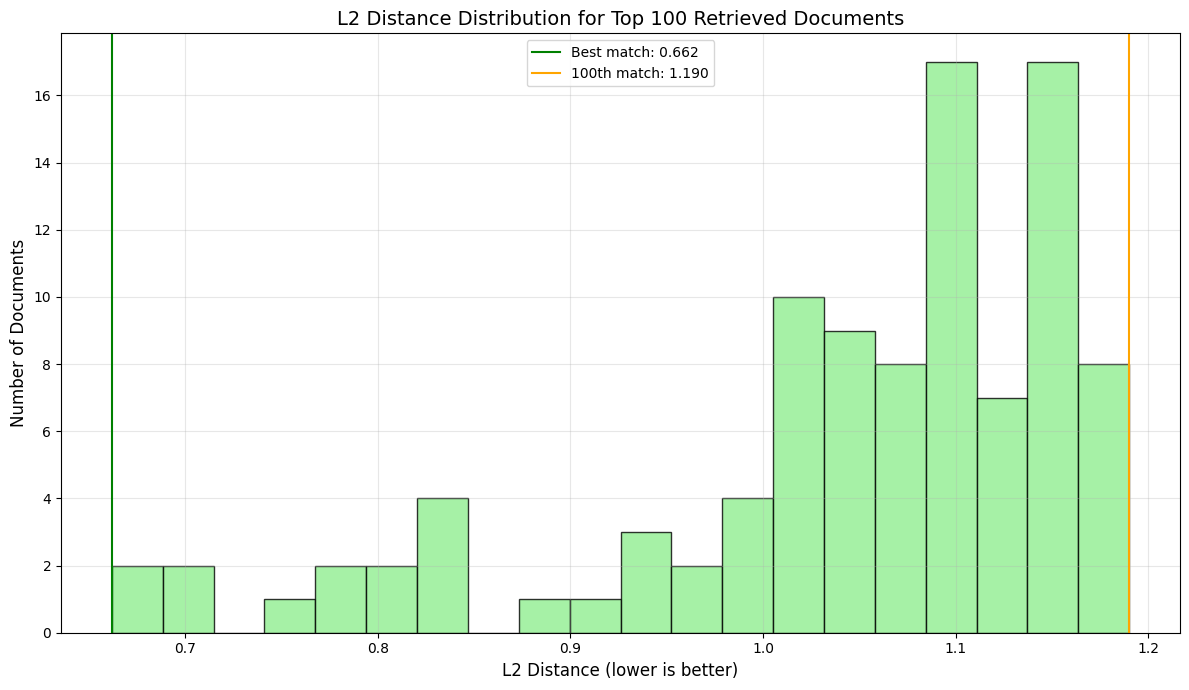

In [7]:
# Visualization

# === Step 1: Import Libraries ===
import matplotlib.pyplot as plt
import numpy as np
import faiss
import pickle
import random
from sentence_transformers import SentenceTransformer
from tqdm import tqdm  # For progress bar

# === Step 2: Load FAISS Index and Corpus ===
index_path = '/content/drive/Othercomputers/My Mac/CSCI_104/Week_Project/App/LLM_RAG_index.faiss'
corpus_path = '/content/drive/Othercomputers/My Mac/CSCI_104/Week_Project/App/LLM_RAG_threads.pkl'

index = faiss.read_index(index_path)
with open(corpus_path, 'rb') as f:
    df = pickle.load(f)

# === Step 3: Embed a Sample Query ===
model = SentenceTransformer("all-MiniLM-L6-v2")
query = "How do I replace the sunroof seals?"
query_embedding = model.encode([query]).astype(np.float32)

# === Step 4: Retrieve Top 1000 Documents Using FAISS ===
k = 1000  # Number of documents to retrieve
D, I = index.search(query_embedding, k=k)

# === Step 5: Plot Histogram of Distances ===
plt.figure(figsize=(12, 7))
plt.hist(D[0], bins=30, color='steelblue', edgecolor='black', alpha=0.8)

# Add vertical lines for reference points
plt.axvline(x=np.median(D[0]), color='red', linestyle='--',
           label=f'Median: {np.median(D[0]):.3f}')
plt.axvline(x=D[0][0], color='green', linestyle='-',
           label=f'Best match: {D[0][0]:.3f}')
plt.axvline(x=D[0][999], color='orange', linestyle='-',
           label=f'1000th match: {D[0][999]:.3f}')

plt.title("L2 Distance Distribution for Top 1000 Retrieved Documents", fontsize=14)
plt.xlabel("L2 Distance (lower is better)", fontsize=12)
plt.ylabel("Number of Documents", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# === Step 6: Print Statistics ===
print(f"Top 1000 Documents Statistics:")
print(f"- Mean Distance: {np.mean(D[0]):.4f}")
print(f"- Median Distance: {np.median(D[0]):.4f}")
print(f"- Min Distance (Best Match): {np.min(D[0]):.4f}")
print(f"- Max Distance (1000th Match): {np.max(D[0]):.4f}")
print(f"- 10th Percentile: {np.percentile(D[0], 10):.4f}")
print(f"- 90th Percentile: {np.percentile(D[0], 90):.4f}")

# === Step 7: Create a Zoomed Inset of the Top 100 Documents ===
# Create a small subplot showing the distribution of just the top 100 docs
plt.figure(figsize=(12, 7))
plt.hist(D[0][:100], bins=20, color='lightgreen', edgecolor='black', alpha=0.8)
plt.axvline(x=D[0][0], color='green', linestyle='-',
           label=f'Best match: {D[0][0]:.3f}')
plt.axvline(x=D[0][99], color='orange', linestyle='-',
           label=f'100th match: {D[0][99]:.3f}')
plt.title("L2 Distance Distribution for Top 100 Retrieved Documents", fontsize=14)
plt.xlabel("L2 Distance (lower is better)", fontsize=12)
plt.ylabel("Number of Documents", fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# Show both plots
plt.show()


## Export to HTML

In [9]:
from nbconvert import HTMLExporter
import nbformat
import codecs
import os
import copy

notebook_path = '/content/drive/Othercomputers/My Mac/CSCI_104/Week_Project/Notebooks/LLM_RAG_ELGASDAVID_RAG.ipynb'
html_path = '/content/drive/Othercomputers/My Mac/CSCI_104/Week_Project/Notebooks/LLM_RAG_ELGASDAVID_RAG.html'

# Verify the file exists
if not os.path.exists(notebook_path):
    print(f"Error: File not found at {notebook_path}")
else:
    # Create the HTML exporter with embedded resources
    html_exporter = HTMLExporter()

    # Configure to embed images, data, and other resources
    html_exporter.embed_images = True

    # Optional: Use the full template which includes more styling
    html_exporter.template_name = 'classic'

    # Set config to embed all resources
    html_exporter.exclude_input_prompt = False
    html_exporter.exclude_output_prompt = False

    try:
        # Read the notebook
        with open(notebook_path, 'r', encoding='utf-8') as notebook_file:
            notebook_content = nbformat.read(notebook_file, as_version=4)

        # Make a deep copy to avoid modifying the original
        notebook_copy = copy.deepcopy(notebook_content)

        # Remove widget metadata if present
        if 'widgets' in notebook_copy.get('metadata', {}):
            del notebook_copy['metadata']['widgets']

        # Sanitize all cell metadata
        for cell in notebook_copy.cells:
            if 'metadata' in cell and 'widgets' in cell['metadata']:
                del cell['metadata']['widgets']

            # Also clean outputs
            if cell.get('cell_type') == 'code' and 'outputs' in cell:
                for output in cell['outputs']:
                    if 'metadata' in output and 'widgets' in output['metadata']:
                        del output['metadata']['widgets']

        # Convert to HTML with embedded resources
        html_data, resources = html_exporter.from_notebook_node(notebook_copy)

        # Check if there are resources to embed
        if resources and 'outputs' in resources:
            print(f"Found {len(resources['outputs'])} resources to embed")

        # Write the HTML file
        with codecs.open(html_path, 'w', encoding='utf-8') as f:
            f.write(html_data)

        print(f"HTML file with embedded resources saved to {html_path}")
    except Exception as e:
        print(f"Error during conversion: {e}")

        # Fallback to basic template
        try:
            print("Attempting fallback method with basic template...")
            html_exporter = HTMLExporter(template_name='basic')
            html_exporter.embed_images = True  # Still try to embed images in fallback

            # Need to reload the notebook for the fallback attempt
            with open(notebook_path, 'r', encoding='utf-8') as notebook_file:
                notebook_content = nbformat.read(notebook_file, as_version=4)

            notebook_copy = copy.deepcopy(notebook_content)

            # Apply the same widget cleanup
            if 'widgets' in notebook_copy.get('metadata', {}):
                del notebook_copy['metadata']['widgets']

            for cell in notebook_copy.cells:
                if 'metadata' in cell and 'widgets' in cell['metadata']:
                    del cell['metadata']['widgets']

                if cell.get('cell_type') == 'code' and 'outputs' in cell:
                    for output in cell['outputs']:
                        if 'metadata' in output and 'widgets' in output['metadata']:
                            del output['metadata']['widgets']

            html_data, resources = html_exporter.from_notebook_node(notebook_copy)

            with codecs.open(html_path, 'w', encoding='utf-8') as f:
                f.write(html_data)

            print(f"Fallback method: HTML file saved to {html_path}")
        except Exception as e2:
            print(f"Fallback method also failed: {e2}")

HTML file with embedded resources saved to /content/drive/Othercomputers/My Mac/CSCI_104/Week_Project/Notebooks/LLM_RAG_ELGASDAVID_RAG.html
